In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from transformers import BertTokenizer, BertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

C:\Users\holte\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('features.csv')

In [3]:
df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: eval(x))
df['title_lemmatized'] = df['title_lemmatized'].apply(lambda x: eval(x))
df['full_text'] = df['title_lemmatized'].apply(lambda tokens: " ".join(tokens)) + " " + df['text_lemmatized'].apply(lambda tokens: " ".join(tokens))

In [4]:
X = df.drop(columns=['label'])
y = df['label']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apoi împărțim din ce a rămas în train (80%) -> train (64%) și val (16%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Construim DataFrame-urile
df_train = df.loc[X_train.index].reset_index(drop=True)
df_val = df.loc[X_val.index].reset_index(drop=True)
df_test = df.loc[X_test.index].reset_index(drop=True)

<Axes: xlabel='label', ylabel='Count'>

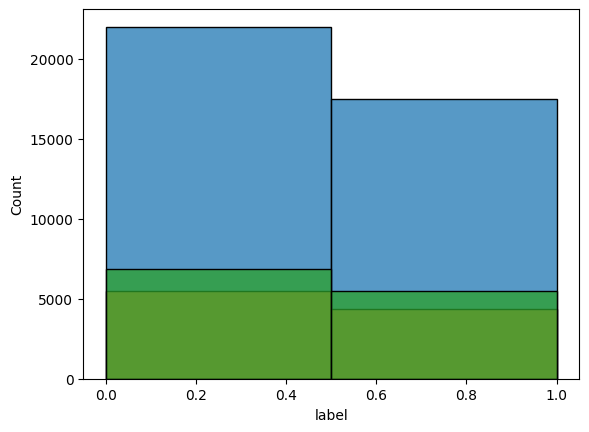

In [5]:
# Grafic distribuție
sns.histplot(y_train, bins=2)
sns.histplot(y_val, bins=2)
sns.histplot(y_test, bins=2)

1. TF-IDF

In [6]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    max_features=5000,
    stop_words='english',
    sublinear_tf=True
)

X_train_tf_idf = vectorizer.fit_transform(df_train['full_text'])
X_val_tf_idf = vectorizer.transform(df_val['full_text'])
X_test_tf_idf = vectorizer.transform(df_test['full_text'])

df_train['tfidf_embedding'] = list(X_train_tf_idf.toarray())
df_val['tfidf_embedding'] = list(X_val_tf_idf.toarray())
df_test['tfidf_embedding'] = list(X_test_tf_idf.toarray())

In [7]:
vectorizer_ngrams = TfidfVectorizer(
    ngram_range=(1, 3),    
    max_features=10000,     
    stop_words='english',   
    sublinear_tf=True       
)

X_train_ngrams = vectorizer_ngrams.fit_transform(df_train['full_text'])
X_val_ngrams = vectorizer_ngrams.transform(df_val['full_text'])
X_test_ngrams = vectorizer_ngrams.transform(df_test['full_text'])


df_train['tfidf_ngrams'] = list(X_train_ngrams.toarray())
df_val['tfidf_ngrams'] = list(X_val_ngrams.toarray())
df_test['tfidf_ngrams'] = list(X_test_ngrams.toarray())

2. GloVe

In [8]:
df_train['full_tokens'] = df_train['title_lemmatized'] + df_train['text_lemmatized']
df_val['full_tokens'] = df_val['title_lemmatized'] + df_val['text_lemmatized']
df_test['full_tokens'] = df_test['title_lemmatized'] + df_test['text_lemmatized']


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['full_tokens'])

print('Numarul de cuvinte:', len(tokenizer.word_index))
df_dictionar = pd.DataFrame(tokenizer.word_index.items(), columns=['cuvant', 'index'])
print(df_dictionar.head())

Numarul de cuvinte: 170582
      cuvant  index
0        say      1
1      trump      2
2      state      3
3      would      4
4  president      5


In [9]:
def load_glove_dict(file_path, dim=100):
    glove_dict = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype=np.float32)
            glove_dict[word] = vector
    return glove_dict

glove_dict = load_glove_dict('glove.6B.100d.txt', dim=100)

In [10]:
def average_embedding(tokens, embedding_dict, dim=100):
    vectors = [embedding_dict[word] for word in tokens if word in embedding_dict]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

In [11]:
df_train['glove_embedding'] = [average_embedding(t, glove_dict, dim=100) for t in df_train['full_tokens']]
df_val['glove_embedding'] = [average_embedding(t, glove_dict, dim=100) for t in df_val['full_tokens']]
df_test['glove_embedding'] = [average_embedding(t, glove_dict, dim=100) for t in df_test['full_tokens']]

3. Word2vec - CBOW

In [12]:
w2v_model_cbow = Word2Vec(
    sentences=df_train['full_tokens'],     # lista de liste de tokeni
    vector_size=100,                       # dimensiunea vectorilor
    window=10,                             # dimensiunea ferestrei context
    min_count=2,                          # ignoră cuvintele cu frecvență sub 2
    workers=4,                            # numărul de thread-uri
    sg=0                                   # 0 = CBOW
)

In [13]:
w2v_model_cbow.wv.most_similar('election', topn=10)

[('electoral', 0.6232032179832458),
 ('primary', 0.562582790851593),
 ('candidate', 0.552706778049469),
 ('race', 0.5206029415130615),
 ('outcome', 0.49976029992103577),
 ('vote', 0.490852028131485),
 ('voter', 0.47768405079841614),
 ('voting', 0.47065478563308716),
 ('demcorats', 0.46857553720474243),
 ('electorate', 0.4681573808193207)]

In [14]:
def average_embedding_w2v(tokens, model, dim=500):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

In [15]:
df_train['w2v_embedding'] = [average_embedding_w2v(t, w2v_model_cbow) for t in df_train['full_tokens']]
df_val['w2v_embedding'] = [average_embedding_w2v(t, w2v_model_cbow) for t in df_val['full_tokens']]
df_test['w2v_embedding'] = [average_embedding_w2v(t, w2v_model_cbow) for t in df_test['full_tokens']]

4. Bert Base uncased

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

In [18]:
def get_bert_embeddings(texts, tokenizer, model, max_length=512):
    embeddings = []
    
    with torch.no_grad():
        for text in tqdm(texts):
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=max_length
            )
            inputs = {key: val.to(device) for key, val in inputs.items()}
            
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.squeeze(0).cpu().numpy())
    
    return embeddings

df_train['bert_embedding'] = get_bert_embeddings(df_train['full_text'], tokenizer, model)
df_val['bert_embedding'] = get_bert_embeddings(df_val['full_text'], tokenizer, model)
df_test['bert_embedding'] = get_bert_embeddings(df_test['full_text'], tokenizer, model)


100%|██████████| 12354/12354 [08:11<00:00, 25.12it/s]


In [19]:
df_train.columns

Index(['title', 'text', 'label', 'clean_text', 'clean_title',
       'clean_text_without_stopwords', 'clean_title_without_stopwords',
       'text_lemmatized', 'title_lemmatized', 'gunning_fog', 'smog_index',
       'subjectivity', 'title_text_similarity', 'words_per_sentence',
       'adv_ratio_title', 'noun_ratio_title', 'words_per_title',
       'syllables_per_word', 'uppercase_per_title',
       'uppercase_ratio_title_text', 'adj_ratio_text', 'adv_ratio_text',
       'verb_ratio_text', 'noun_ratio_text', 'short_sentences_ratio',
       'long_sentences_ratio', 'full_text', 'tfidf_embedding', 'tfidf_ngrams',
       'full_tokens', 'glove_embedding', 'w2v_embedding', 'bert_embedding'],
      dtype='object')

In [20]:
cols_to_drop = ['clean_text', 'clean_title',
       'clean_text_without_stopwords', 'clean_title_without_stopwords',
       'text_lemmatized', 'title_lemmatized', 'full_text', 'full_tokens',]

df_train = df_train.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)
df_val = df_val.drop(columns=cols_to_drop)


In [21]:
df_train.to_csv('train_embeddings.csv', index=False)
df_test.to_csv('test_embeddings.csv', index=False)
df_val.to_csv('val_embeddings.csv', index=False)